In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, adjusted_rand_score
)
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline
import joblib
from sklearn.preprocessing import StandardScaler
import zipfile

In [5]:
zip_path = "/heart+disease.zip"

processed_files = [
    "heart+disease/processed.cleveland.data",
    "heart+disease/processed.hungarian.data",
    "heart+disease/processed.switzerland.data",
    "heart+disease/processed.va.data",
]

cols = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach",
    "exang","oldpeak","slope","ca","thal","target"
]

rows = []
with zipfile.ZipFile(zip_path, 'r') as z:
    for pf in processed_files:
        raw = z.read(pf).decode('latin1').splitlines()
        for line in raw:
            if not line.strip():
                continue
            parts = [p.strip() for p in line.split(",")]
            if len(parts) < len(cols):
                parts += ["?"] * (len(cols) - len(parts))
            elif len(parts) > len(cols):
                parts = parts[:len(cols)]
            rows.append(parts)

df_raw = pd.DataFrame(rows, columns=cols)

df_raw.replace("?", pd.NA, inplace=True)
for c in cols:
    df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

print("Shape:", df_raw.shape)
print("Missing values per column:\n", df_raw.isna().sum())
df_raw.head()


Shape: (920, 14)
Missing values per column:
 age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Missing values per column:
 age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64


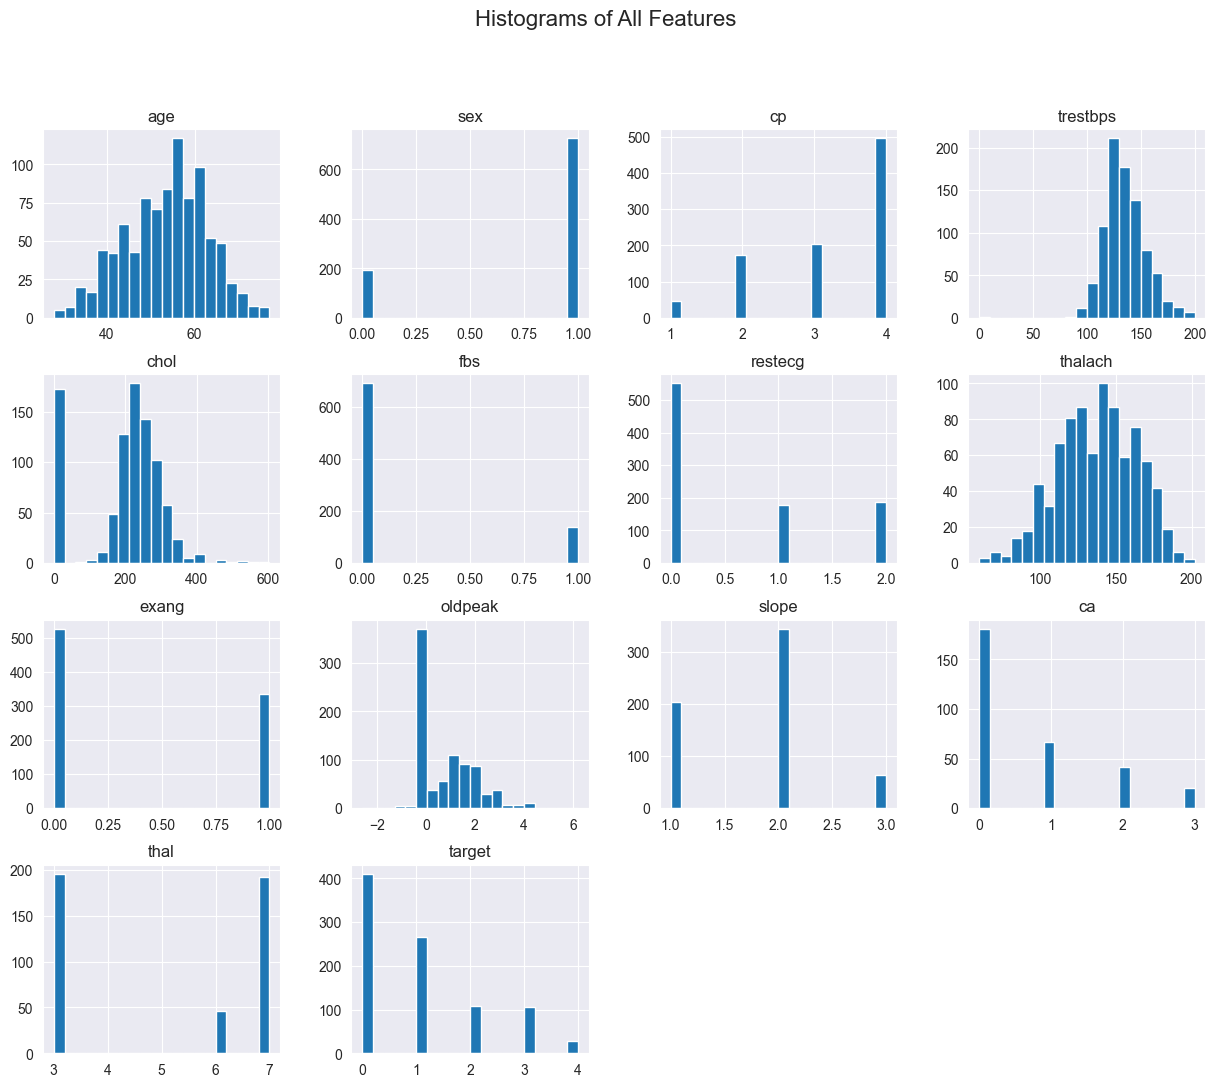

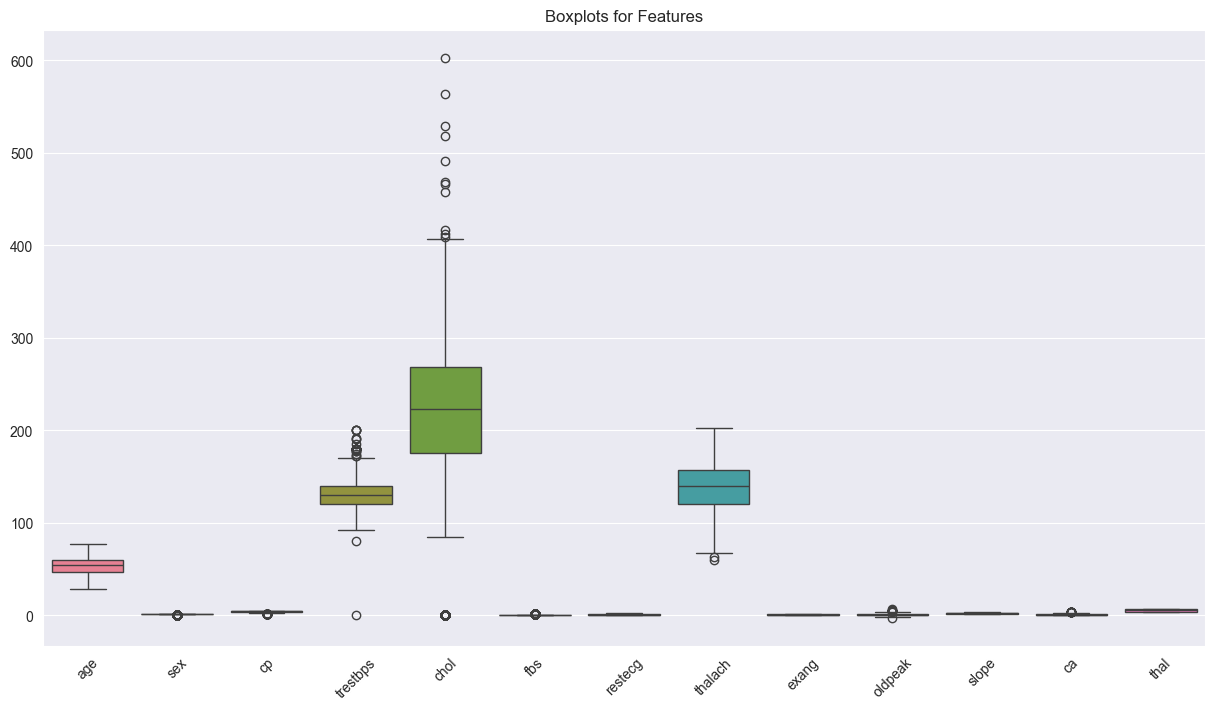

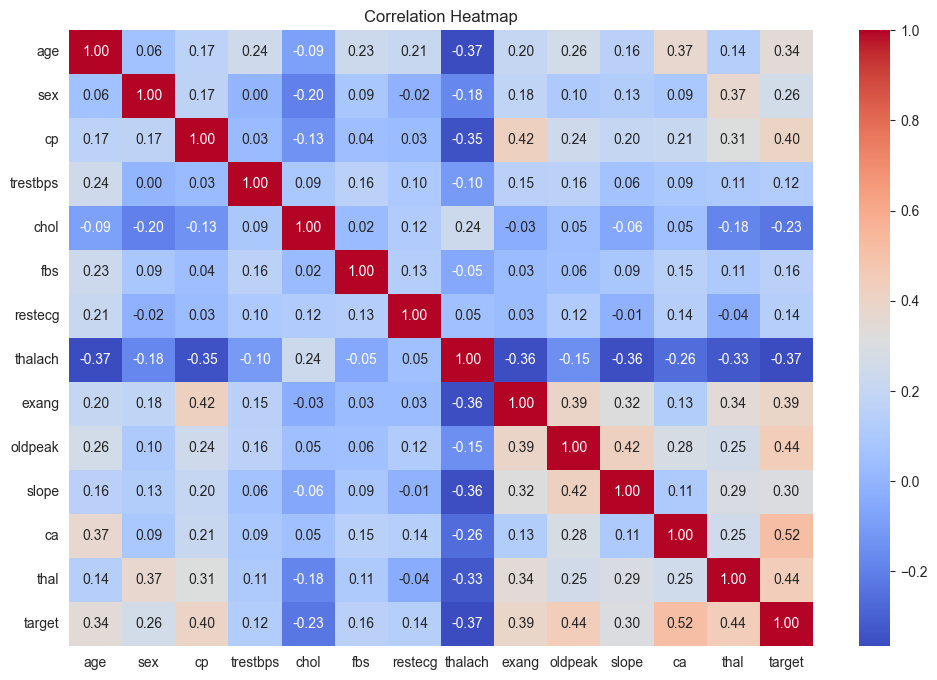

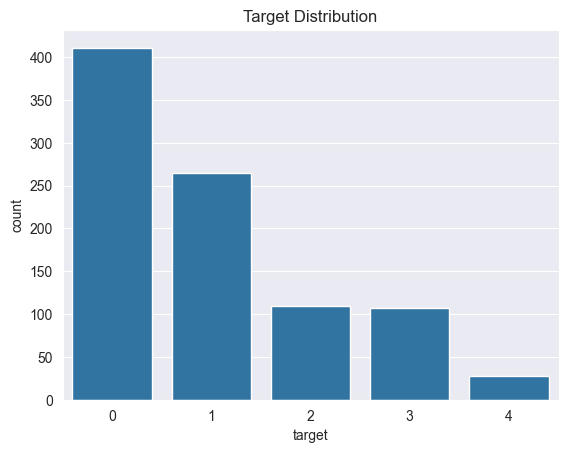

In [6]:
# Missing Values
df = df_raw.copy()

print("Missing values per column:\n", df.isna().sum())
# Histograms
df.hist(figsize=(15,12), bins=20)
plt.suptitle("Histograms of All Features", fontsize=16)
plt.show()

# Boxplots
plt.figure(figsize=(15,8))
sns.boxplot(data=df.drop(columns=["target"]))
plt.xticks(rotation=45)
plt.title("Boxplots for Features")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Target Distribution
sns.countplot(x="target", data=df)
plt.title("Target Distribution")
plt.show()


In [7]:
for col in ["ca", "thal", "slope"]:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

for col in df.columns:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

def remove_outliers(data, cols):
    clean_data = data.copy()
    for col in cols:
        Q1 = clean_data[col].quantile(0.25)
        Q3 = clean_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        clean_data = clean_data[(clean_data[col] >= lower) & (clean_data[col] <= upper)]
    return clean_data

numeric_cols = ["age","trestbps","chol","thalach","oldpeak"]
df = remove_outliers(df, numeric_cols)

df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

X = df.drop("target", axis=1)
y = df["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X = pd.DataFrame(X_scaled, columns=X.columns)
df_ready = pd.concat([X, y.reset_index(drop=True)], axis=1)

print(df_ready.shape)
print("\n", df_ready["target"].value_counts())
df_ready.head()


Shape بعد التنظيف: (702, 14)
توزيع الهدف:
 target
0    378
1    324
Name: count, dtype: int64


C:\Users\zeyad\AppData\Local\Temp\ipykernel_151596\304819784.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)
C:\Users\zeyad\AppData\Local\Temp\ipykernel_151596\304819784.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1.081807,0.563093,-2.240518,0.909807,-0.163268,2.295181,1.629035,0.356498,-0.709374,1.593427,2.413793,-0.391782,1.336062,0
1,1.502136,0.563093,0.898890,1.889384,0.929472,-0.435695,1.629035,-1.410649,1.409693,0.747536,0.369785,4.217680,-0.537271,1
2,1.502136,0.563093,0.898890,-0.722822,-0.245739,-0.435695,1.629035,-0.527075,1.409693,1.910637,0.369785,2.681193,1.960507,1
3,-1.650329,0.563093,-0.147579,-0.069770,0.187234,-0.435695,-0.758403,1.913271,-0.709374,2.862265,2.413793,-0.391782,-0.537271,0
4,-1.230000,-1.775907,-1.194048,-0.069770,-0.761182,-0.435695,1.629035,1.282147,-0.709374,0.641799,-1.674223,-0.391782,-0.537271,0


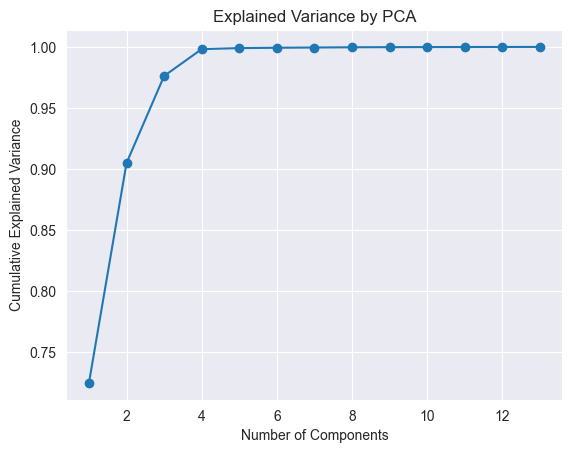

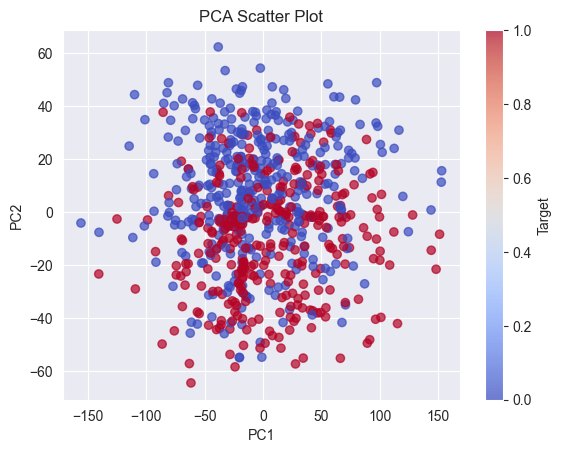

Number of components for 95% variance: 3


In [8]:
X = df.drop("target", axis=1)
y = df["target"]

pca = PCA()
X_pca = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
cum_var = explained_var.cumsum()

plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA")
plt.show()

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA Scatter Plot")
plt.colorbar(label="Target")
plt.show()

n_components = (cum_var >= 0.95).argmax() + 1
print("Number of components for 95% variance:", n_components)


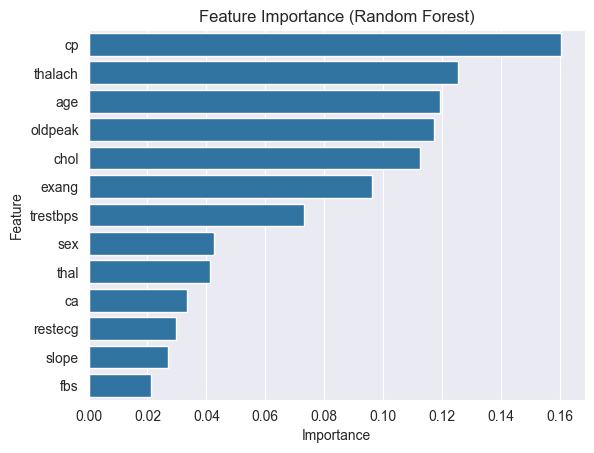

Selected features by RFE: ['sex', 'cp', 'fbs', 'exang', 'oldpeak']
Selected features by Chi-Square: ['cp', 'exang', 'oldpeak', 'ca', 'thal']


In [9]:
# Random Forest Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Feature Importance (Random Forest)")
plt.show()

# RFE with Logistic Regression
lr = LogisticRegression(max_iter=2000)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X, y)
print("Selected features by RFE:", X.columns[rfe.support_].tolist())

# Chi-Square Test
X_scaled = MinMaxScaler().fit_transform(X)
chi2_selector = SelectKBest(chi2, k=5)
chi2_selector.fit(X_scaled, y)
print("Selected features by Chi-Square:", X.columns[chi2_selector.get_support()].tolist())


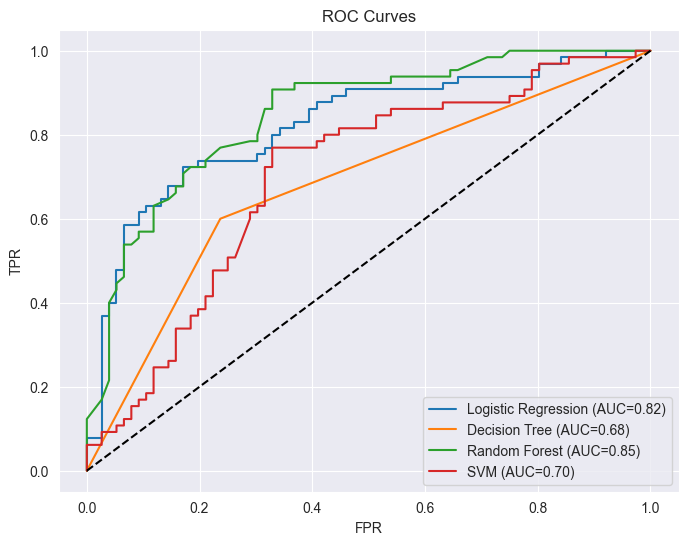

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.765957,0.750000,0.738462,0.744186,0.823684
1,Decision Tree,0.687943,0.684211,0.600000,0.639344,0.681579
2,Random Forest,0.773050,0.770492,0.723077,0.746032,0.848178
3,SVM,0.624113,0.620000,0.476923,0.539130,0.700810


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = []
plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    results.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob)
    ])

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,y_prob):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curves")
plt.legend()
plt.show()

pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","AUC"])


In [11]:
# Random Forest Tuning
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=10, cv=5, scoring="f1", random_state=42)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

# Logistic Regression Tuning
lr_params = {"C": [0.01, 0.1, 1, 10], "solver": ["liblinear", "lbfgs"]}
lr_search = GridSearchCV(LogisticRegression(max_iter=5000), lr_params, cv=5, scoring="f1")
lr_search.fit(X_train, y_train)
lr_best = lr_search.best_estimator_

# SVM Tuning
svm_params = {"C": [0.1, 1, 10], "kernel": ["linear","rbf"], "gamma": ["scale","auto"]}
svm_search = GridSearchCV(SVC(probability=True), svm_params, cv=5, scoring="f1")
svm_search.fit(X_train, y_train)
svm_best = svm_search.best_estimator_

print("Best RF:", rf_best)
print("Best LR:", lr_best)
print("Best SVM:", svm_best)


Best RF: RandomForestClassifier(max_depth=10, min_samples_leaf=2, random_state=42)
Best LR: LogisticRegression(C=10, max_iter=5000, solver='liblinear')
Best SVM: SVC(C=10, kernel='linear', probability=True)


C:\Users\zeyad\PyCharmMiscProject\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\zeyad\PyCharmMiscProject\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\zeyad\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\zeyad\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\zeyad\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _exe

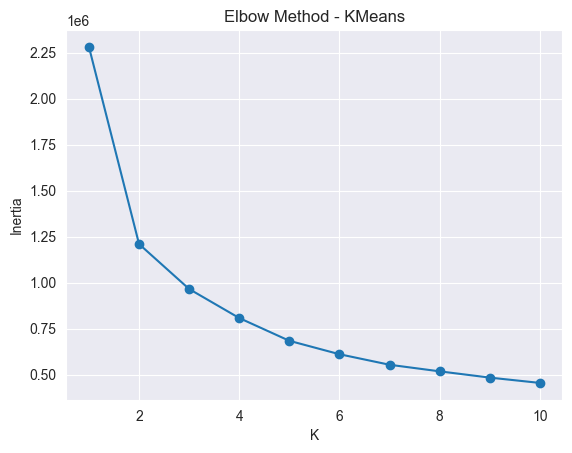

ARI (KMeans vs Target): 0.01554906095573124


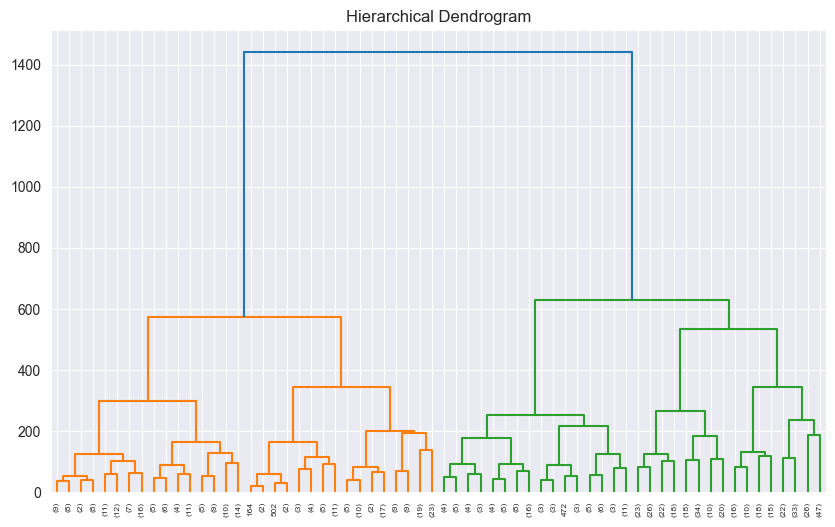

ARI (Hierarchical vs Target): 0.026579872494111024


In [12]:
# KMeans Elbow
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia, marker="o")
plt.xlabel("K"); plt.ylabel("Inertia")
plt.title("Elbow Method - KMeans")
plt.show()

# KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X)
print("ARI (KMeans vs Target):", adjusted_rand_score(y, clusters_kmeans))

# Hierarchical Clustering
linked = linkage(X, method="ward")
plt.figure(figsize=(10,6))
dendrogram(linked, truncate_mode="level", p=5)
plt.title("Hierarchical Dendrogram")
plt.show()

hc = AgglomerativeClustering(n_clusters=2, linkage="ward")
clusters_hc = hc.fit_predict(X)
print("ARI (Hierarchical vs Target):", adjusted_rand_score(y, clusters_hc))


In [15]:
# Pipeline with Scaling + Best RF
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", rf_best)
])
pipeline.fit(X, y)

joblib.dump(pipeline, "/final_pipeline.pkl")
print("Final pipeline saved as final_pipeline.pkl")


Final pipeline saved as final_pipeline.pkl
